# 🌱 Learning Demo Sandbox: Linear Regression and Parameter Optimization by Gradient Descent

**Collaborators:** Amy Zhang (lead), ChatGPT, Perplexity AI, Gemini AI

**Date:** June 2025

---

## Overview

This notebook introduces how machines learn from data by adjusting internal parameters through **gradient descent**—a mathematical process that minimizes prediction error over time. Our focus is on **Linear Regression**, a model that estimates the relationship between one or more input (i.e. independent) variables and a continuous output (i.e. dependent) variable by *iteratively optimizing a linear equation*.

While Linear Regression is also a **statistical technique** familiar to many (used to compute correlation strength, e.g., Pearson’s *r*), here we explore it as a **learning system**—one that adapts its weights using feedback from prediction errors, guided by the shape of the loss landscape.

Even in our simple, univariate examples, the shift is significant:

> The “line of best fit” is no longer just a historical artifact of external trends—it becomes a material record of system-internalized learning, shaped by the model’s iterative effort to minimize error across inputs.

In a world where few relationships are truly linear, and uncertainty is everywhere, learning how machines navigate—even imperfectly—can help us build tools that are better attuned to complex, evolving conditions.

---

## Preview: Where We're Going

While gradient descent is core to many ML models, not all models learn via parameter updates. This notebook also sets the stage for understanding:

* **Parameter Optimization**: Internal adjustments (like weights) based on gradient-based feedback
* **Hyperparameter Optimization**: Pre-model configurations (like *k* in k-NN) that aren't learned during training
* **Differentiability Matters**: Gradient descent requires a *smooth*, continuous loss surface—so it’s not applicable everywhere (e.g., decision trees use “greedy” optimization strategies, not gradient-based ones)

Focusing on how optimization is shaped by both mathematical structure and model design helps clarify—just as this foundational notebook aims to do—what “learning” in machine learning actually entails. 

---

## Our Models

We're using 2019 weather records from the **OSLO** station, one of only three with complete data coverage.

### Linear Regression #1: `temp_mean ~ time`

* **Question**: Can a linear model predict temperature based on calendar day?
* **Spoiler**: The optimizer behaves well, but the data is **nonlinear**—the model can’t capture seasonal dynamics with just a line.
* **Lesson**: Optimization success ≠ modeling success.

### Linear Regression #2: `temp_mean ~ global_radiation`

* **Question**: Can radiation serve as a more predictive feature for temperature?
* **Pearson’s *r*** ≈ 0.55
* **Takeaway**: Feature selection matters; some relationships are closer to linear than others.

---

## Objectives

* Preprocess 2019 OSLO weather data
* Train two linear models using gradient descent
* Track and visualize optimization progress
* Compare model fits via:

  * 3D surface plots
  * Contour plots
* Introduce key concepts for future models: loss, gradient, optimization, and parameter tuning


# 1. Import Libraries and Datasets

In [73]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# System and environment
import os

# 🔒 Set seed for reproducibility
np.random.seed(42)


In [74]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Dataset-weather-prediction-dataset-processed.csv'

# Import 
weather_df = pd.read_csv(csv_file_path)  

# Verify the import
print(weather_df.shape)
print(weather_df.dtypes.to_string())

(22950, 170)
DATE                             int64
MONTH                            int64
BASEL_cloud_cover                int64
BASEL_wind_speed               float64
BASEL_humidity                 float64
BASEL_pressure                 float64
BASEL_global_radiation         float64
BASEL_precipitation            float64
BASEL_snow_depth                 int64
BASEL_sunshine                 float64
BASEL_temp_mean                float64
BASEL_temp_min                 float64
BASEL_temp_max                 float64
BELGRADE_cloud_cover             int64
BELGRADE_humidity              float64
BELGRADE_pressure              float64
BELGRADE_global_radiation      float64
BELGRADE_precipitation         float64
BELGRADE_sunshine              float64
BELGRADE_temp_mean             float64
BELGRADE_temp_min              float64
BELGRADE_temp_max              float64
BUDAPEST_cloud_cover             int64
BUDAPEST_humidity              float64
BUDAPEST_pressure              float64
BUDAPEST_glo

# 2. Linear Regression Model #1: `temp_mean ~ time`

## A. (Model #1) Prepare Inputs: Extract & Transform Time-Based Temperature Data

In [77]:
# Convert the 'DATE' column from string (YYYYMMDD) to datetime format
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], format='%Y%m%d')

# Filter to OSLO temperature data for the year 2019
temp_time_oslo_2019 = weather_df[
    (weather_df['DATE'].dt.year == 2019)
][['DATE', 'OSLO_temp_mean']].dropna()

# Convert dates to numeric time values: day of year (1–365); this will serve as our feature input for X
temp_time_oslo_2019['day_of_year'] = temp_time_oslo_2019['DATE'].dt.dayofyear

# Extract model input (X) and target (y) for training
temp_time_X = temp_time_oslo_2019['day_of_year'].values.reshape(-1, 1)  # Feature: time
temp_time_y = temp_time_oslo_2019['OSLO_temp_mean'].values.reshape(-1, 1)  # Target: temperature


In [78]:
temp_time_oslo_2019.head()

,DATE,OSLO_temp_mean,day_of_year
21550,2019-01-01,4.7,1
21551,2019-01-02,1.0,2
21552,2019-01-03,1.0,3
21553,2019-01-04,2.3,4
21554,2019-01-05,3.3,5


## B. (Model #1) Scale Data and Initialize Gradient Descent Set-up

⚠️ Note: The **bias** (y-intercept) allows the model to fit data **without being forced to pass through the origin**. It shifts the line vertically, enabling better alignment with real-world patterns.

Even so, we choose to initialize both the **bias (θ₀)** and the **weight (θ₁)** at **0.0** for clarity and neutrality:

1. **Symmetry** – Starting at zero gives the model an unbiased starting point, allowing it to explore all directions equally during early training.  
2. **No prior assumptions** – We don't encode any preconceptions about where the line should begin; we let the model learn entirely from the data.

This zero-based initialization is common in simple models and works well here, especially since our inputs are scaled.


In [80]:
# Store mean and std for later unscaling
temp_time_y_mean = temp_time_y.mean()
temp_time_y_std = temp_time_y.std()

# Feature scaling: normalize input and target to improve convergence
temp_time_X_scaled = (temp_time_X - temp_time_X.mean()) / temp_time_X.std()
temp_time_y_scaled = (temp_time_y - temp_time_y.mean()) / temp_time_y.std()

# Set key hyperparameters
temp_time_alpha = 0.01           # Learning rate (step size for gradient descent)
temp_time_n_iterations = 1000    # Total number of training iterations
temp_time_m = len(temp_time_X_scaled)     # Number of data points (samples)

# Initialize model parameters
temp_time_theta0 = 0.0   # Intercept (bias)
temp_time_theta1 = 0.0   # Weight (slope)

# Initialize tracking lists for visualization and analysis
temp_time_J_history = []              # Track cost (loss) over time
temp_time_theta0_history = []        # Track intercept values per iteration
temp_time_theta1_history = []        # Track slope values per iteration
temp_time_grad_theta0_history = []   # Track gradient of theta0 over time
temp_time_grad_theta1_history = []   # Track gradient of theta1 over time


## C. (Model #1) Run Linear Model and Update Parameters via Gradient Descent

⚠️ Note: This is **not** formal backpropagation (used in multi-layer neural networks), but **direct gradient descent** applied to a single-layer linear model. Because the model has no hidden layers, the gradients are straightforward to compute manually and update.

💬 Quick clarification on terminology:
- **Backpropagation** calculates gradients (∂Loss/∂Weights) but does **not** update weights.
- **Gradient Descent** performs the **actual optimization step**: it updates the weights using the gradients.


In [82]:
# Run gradient descent loop to iteratively update model parameters
for _ in range(temp_time_n_iterations):
    
    # ➡️ FORWARD PASS: Predict y values using current theta values
    temp_time_y_pred = temp_time_theta0 + temp_time_theta1 * temp_time_X_scaled

    # 🧮 LOSS: Compute prediction error (residuals)
    temp_time_error = temp_time_y_pred - temp_time_y_scaled

    # 💥 COST: Mean Squared Error (scaled by 1/2 for mathematical convenience)
    temp_time_cost = (1 / (2 * temp_time_m)) * np.sum(temp_time_error**2)
    temp_time_J_history.append(temp_time_cost)

    # 📉 GRADIENT CALCULATION: Compute partial derivatives of cost w.r.t. parameters
    temp_time_d_theta0 = (1 / temp_time_m) * np.sum(temp_time_error)                # ∂J/∂theta0
    temp_time_d_theta1 = (1 / temp_time_m) * np.sum(temp_time_error * temp_time_X_scaled)    # ∂J/∂theta1

    # Store gradients for optional plotting/debugging
    temp_time_grad_theta0_history.append(temp_time_d_theta0)
    temp_time_grad_theta1_history.append(temp_time_d_theta1)

    # 🔁 PARAMETER UPDATE: Move against gradient to minimize loss
    temp_time_theta0 -= temp_time_alpha * temp_time_d_theta0
    temp_time_theta1 -= temp_time_alpha * temp_time_d_theta1

    # Track updated theta values over time
    temp_time_theta0_history.append(temp_time_theta0)
    temp_time_theta1_history.append(temp_time_theta1)


## D. (Model #1) Analyze Model Performance

### 📉 Model Performance Summary: `temp_mean ~ time`

* **θ₀ (Intercept)**: −9.23 × 10⁻¹⁷
* **θ₁ (Slope)**: 0.1601
* **Final MSE (scaled)**: 0.487
* **R² Score (scaled)**: 0.026
* **Mean Absolute Error (°C)**: 6.43°C

---

The learned slope (**θ₁ ≈ 0.16**) represents a very **shallow upward trend**, which makes sense given the cyclical nature of temperature over the year—**linear models cannot capture seasonal dynamics**.

The **R² score of just 0.026** means that the model explains **only 2.6% of the variance** in temperature—a signal barely stronger than random noise.

Finally, the **Mean Absolute Error of 6.43°C** shows that predictions are, on average, **off by over six degrees**, confirming the model's **weak real-world performance** on this task.

---

#### D.1) Final Parameters Learned
| Metric                | Description                            | Good To Know…                              |
| --------------------- | -------------------------------------- | ------------------------------------------ |
| `theta0`, `theta1`    | Intercept and slope                    | What relationship the model found between the input and temperature        |


In [85]:
print(f"Theta 0 (intercept): {temp_time_theta0}")
print(f"Theta 1 (slope): {temp_time_theta1}")


Theta 0 (intercept): -9.227322102747621e-17
Theta 1 (slope): 0.16010475643851368


#### D.2) Final Loss (Mean-Squared Error)
| Metric                | Description                            | Good To Know…                              |
| --------------------- | -------------------------------------- | ------------------------------------------ |
| Final `J_history[-1]` | Final cost (MSE)                       | Lower = better fit                         |

In [87]:
temp_time_final_mse = temp_time_J_history[-1]
print(f"Final MSE (scaled): {temp_time_final_mse}")


Final MSE (scaled): 0.48718212680399364


#### D.3) R² Score (Scaled)
| Metric                | Description                            | Good To Know…                              |
| --------------------- | -------------------------------------- | ------------------------------------------ |
| `r2_score`            | How well x explains y                  | 0 = no better than mean guess; 1 = perfect |

In [89]:
temp_time_r2 = r2_score(temp_time_y_scaled, temp_time_y_pred)
print(f"R² Score (scaled): {temp_time_r2}")


R² Score (scaled): 0.025635746392012715


#### D.4) Mean Absolute Error (in °C)
Bringing predictions back to the original temperature scale for intuitive interpretability.
| Metric                | Description                            | Good To Know…                              |
| --------------------- | -------------------------------------- | ------------------------------------------ |
| MAE or RMSE           | Real-world prediction error | Helps translate errors into °C             |


In [100]:
### Inverse transform the predictions to restore ground truths manually
# Unscale predictions and actual y values
temp_time_y_pred_real = (temp_time_y_pred * temp_time_y_std) + temp_time_y_mean
temp_time_y_true_real = (temp_time_y_scaled * temp_time_y_std) + temp_time_y_mean

### Compute real world MAE
temp_time_mae_real = mean_absolute_error(temp_time_y_true_real, temp_time_y_pred_real)
print(f"Mean Absolute Error (°C): {temp_time_mae_real}")


Mean Absolute Error (°C): 6.429953070815624


## E. (Model #1) Visualize Loss Curve and Parameter Paths; Compare Model Predictions to Actual Data

- While the loss (MSE) decreases quickly and the model **converges by iteration \~200–300**, the underlying **seasonal temperature pattern is too nonlinear** for a linear model to capture effectively.

- This is a case of a **well-behaved optimizer** (gradient descent is doing its job) paired with a **misaligned model**—linear regression is not expressive enough for the task.

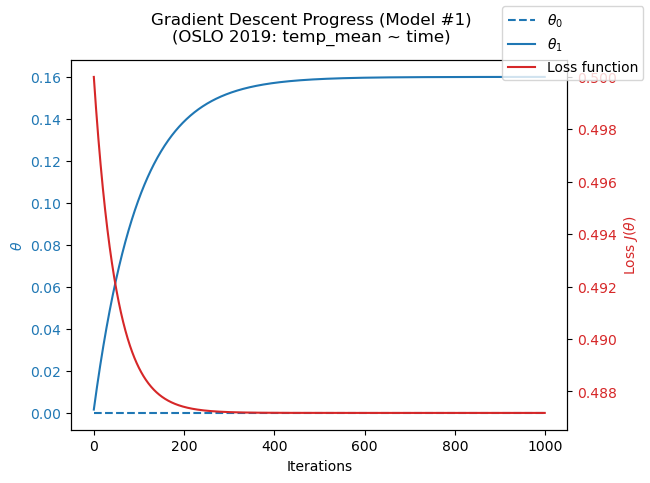

In [116]:
fig1, ax1 = plt.subplots()

# Plot theta values
color = 'tab:blue'
ax1.plot(temp_time_theta0_history, label='$\\theta_0$', linestyle='--', color=color)
ax1.plot(temp_time_theta1_history, label='$\\theta_1$', linestyle='-', color=color)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('$\\theta$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plot cost
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(temp_time_J_history, label='Loss function', color=color)
ax2.set_ylabel('Loss $J(\\theta)$', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig1.suptitle('Gradient Descent Progress (Model #1)\n(OSLO 2019: temp_mean ~ time)')
fig1.legend()
plt.show()


In [186]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/lin_reg_model1_gradient_descent.png'
fig1.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/lin_reg_model1_gradient_descent.png


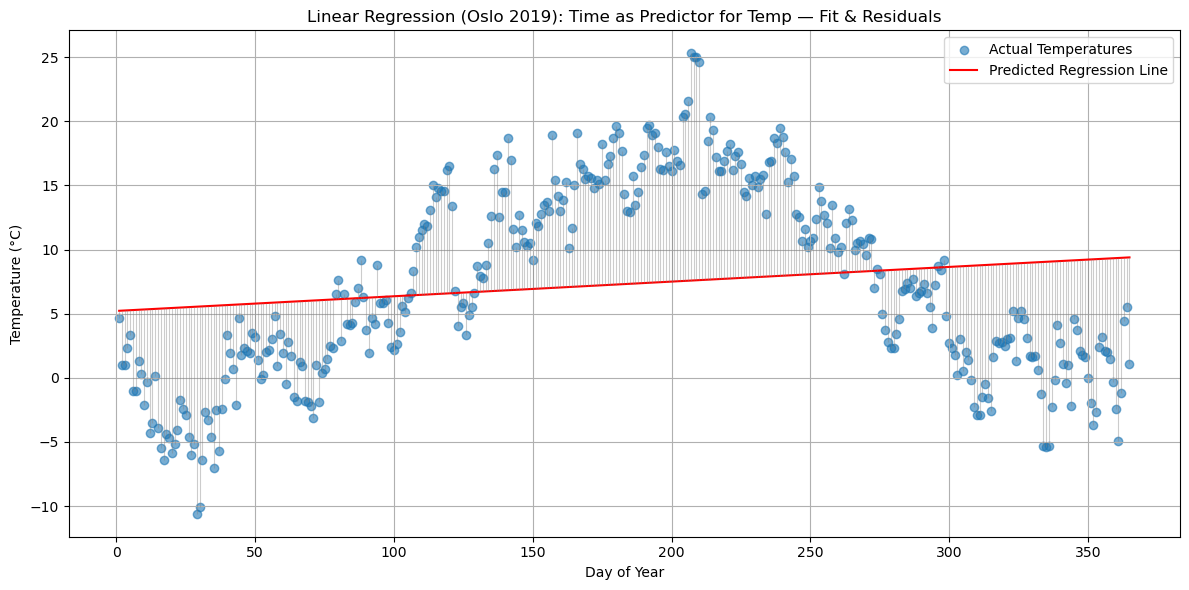

In [188]:
# Reconstruct predictions and true values to original temperature scale
temp_time_y_pred_real = (temp_time_y_pred_scaled * temp_time_y_std) + temp_time_y_mean
temp_time_y_true_real = (temp_time_y_scaled * temp_time_y_std) + temp_time_y_mean

# X-axis: original day-of-year feature
temp_time_X_days = temp_time_X.flatten()  # Already 1–365, ensure 1D shape

# Plot setup
lrtt = plt.figure(figsize=(12, 6))
plt.scatter(temp_time_X_days, temp_time_y_true_real, label='Actual Temperatures', alpha=0.6)
plt.plot(temp_time_X_days, temp_time_y_pred_real, color='red', label='Predicted Regression Line')

# Add residuals (vertical lines from prediction to true value)
for x, y_true, y_pred in zip(temp_time_X_days, temp_time_y_true_real, temp_time_y_pred_real):
    plt.vlines(x, y_pred, y_true, color='gray', alpha=0.4, linewidth=0.8)

# Labels and formatting
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.title('Linear Regression (Oslo 2019): Time as Predictor for Temp — Fit & Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [197]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model1_lin_reg_actual_v_predicted.png'
lrtt.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model1_lin_reg_actual_v_predicted.png


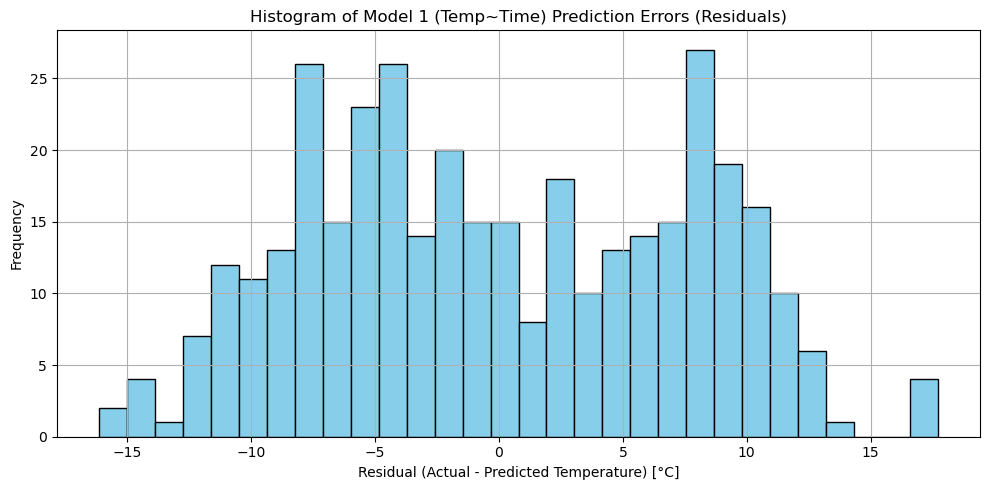

In [193]:
# Calculate residuals (errors) in real temperature scale
residuals = temp_time_y_true_real.flatten() - temp_time_y_pred_real.flatten()

# Plot error histogram
res1 = plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Residual (Actual - Predicted Temperature) [°C]')
plt.ylabel('Frequency')
plt.title('Histogram of Model 1 (Temp~Time) Prediction Errors (Residuals)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [195]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model1_lin_reg_residuals.png'
res1.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model1_lin_reg_residuals.png


## F. (Model #1) Visualize Optimization Path on Loss Surface

### Exploring **Parameter Space** (vs. Data Space)

To better understand how the model learns, we visualize:

* A **3D loss surface** — shows how the Mean Squared Error (MSE) varies with different combinations of model parameters: θ₀ (intercept) and θ₁ (slope).
* A **2D contour plot** — a top-down view of this surface. Each contour line represents a level set: all combinations of (θ₀, θ₁) that yield the same loss.
* The **gradient descent path** — the actual trajectory the model followed as it updated its parameters to minimize loss.
* The **loss surface** is built by evaluating the MSE over a manually defined grid of (θ₀, θ₁) values — often from -2 to 2, but that range can be adjusted to suit the model and the dataset.

  > 🔧 This grid is *not* generated by training — it’s defined by the researcher to give a broad, fixed “slice” of parameter space to examine.
* The **gradient descent path** overlays this surface, showing the sequence of parameter updates from the optimizer during training.

#### F.1) (Model #1) Interactive 3D Loss Surface (Plotly)

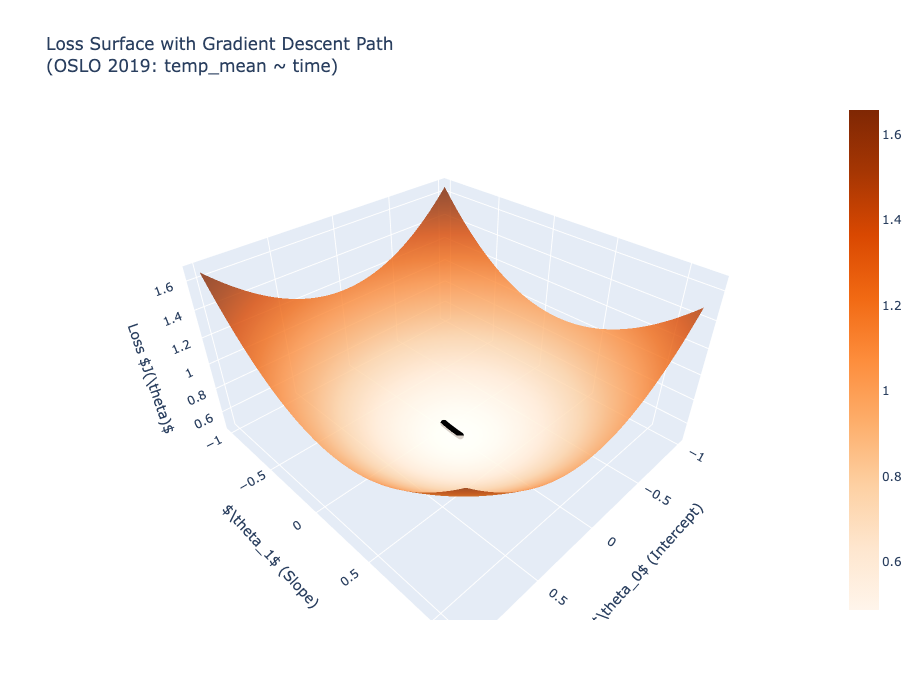

In [339]:
# Define grid for theta0 and theta1
tt_theta0_range = np.linspace(min(temp_time_theta0_history)-1, max(temp_time_theta0_history)+1, 50)
tt_theta1_range = np.linspace(min(temp_time_theta1_history)-1, max(temp_time_theta1_history)+1, 50)
tt_T0, tt_T1 = np.meshgrid(tt_theta0_range, tt_theta1_range)

# Compute loss surface
tt_Z = np.zeros_like(tt_T0)
for i in range(tt_T0.shape[0]):
    for j in range(tt_T0.shape[1]):
        tt_y_pred = tt_T0[i, j] + tt_T1[i, j] * temp_time_X_scaled
        tt_Z[i, j] = (1 / (2 * temp_time_m)) * np.sum((tt_y_pred - temp_time_y_scaled) ** 2)

# Create 3D surface
tt_surface = go.Surface(
    x=tt_theta0_range,
    y=tt_theta1_range,
    z=tt_Z,
    colorscale='Oranges',
    opacity=0.8,
    showscale=True,
    name='Loss Surface'
)

# Add gradient descent path
tt_path = go.Scatter3d(
    x=temp_time_theta0_history,
    y=temp_time_theta1_history,
    z=temp_time_J_history,
    mode='lines+markers',
    line=dict(color='black', width=5),
    marker=dict(size=4, color='black'),
    name='Gradient Descent Path'
)

fig = go.Figure(data=[tt_surface, tt_path])
fig.update_layout(
    scene=dict(
        xaxis_title=r'$\theta_0$ (Intercept)',
        yaxis_title=r'$\theta_1$ (Slope)',
        zaxis_title='Loss $J(\\theta)$'
    ),
    title='Loss Surface with Gradient Descent Path<br>(OSLO 2019: temp_mean ~ time)',
    width=900,
    height=700
)
fig.show()


---
---
---
---
## ⚠️ F.1 (Model #1) – Learning Note: The CRUCIAL Role of `np.random.seed(42)` in Notebook Reproducibility

In an earlier run of our linear regression model, we **forgot to include `np.random.seed(42)`**. As a result, the **loss surface visualization** looks quite different — and noticeably less compelling — compared to the original version (see below).

**🔄 What Changed?**

* In the previous version (shown below), the loss surface had a **pronounced curvature**, and the gradient descent path formed a dramatic, almost orthogonal "splinter" cutting through the valley.
* In the current version (above), the surface looks **flatter and more bowl-like**, and the gradient path gently hugs the valley floor with much less dramatic descent behavior.

**❓ Why?**

* This is due to **random initialization** of model parameters — without setting a random seed (`np.random.seed(42)`), each run begins in a different region of the loss surface.
* Small shifts in the starting point can land the model in a **steep slope** or a **gentle flat** area — both valid but visually very different.
* This doesn't affect the correctness of the algorithm—but it does impact visual storytelling and how easily we can interpret convergence behavior.

**🧪 Takeaway**

* Always set a random seed for reproducibility, especially when showcasing training behavior or debugging model performance.
* Visuals like these don't lie — but they can **vary wildly**, and it's important to understand **why**.

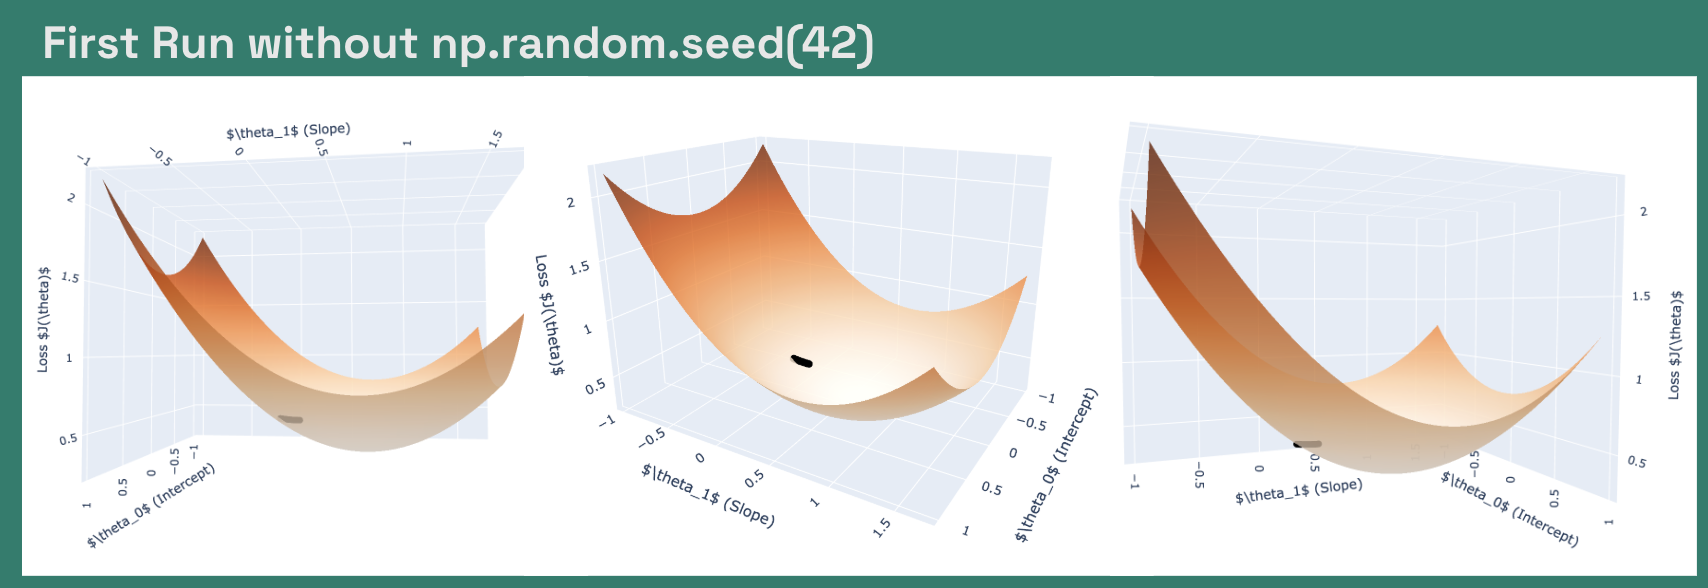

---
---
---
---

#### F.2) (Model #1) 2D Contour Plot of Loss Landscape

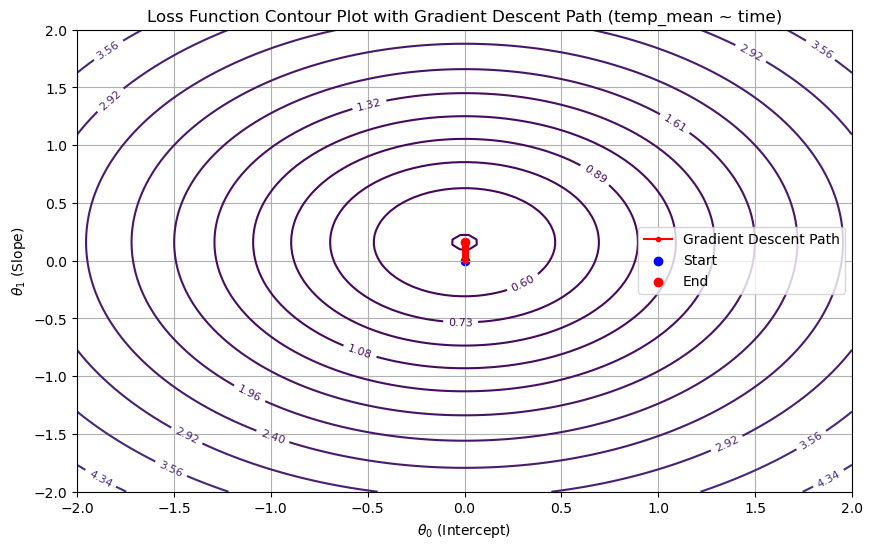

In [358]:
# Create meshgrid for θ₀ and θ₁
"""
We explicitly specify a fixed θ₀ and θ₁ grid here, resulting in a uniform, deterministic 
loss surface. No randomness (e.g., from initialization) is involved in generating this surface.
Hence, this contour plot will look consistent across runs, assuming the data doesn't change.
"""
tt_theta0_vals = np.linspace(-2, 2, 100)
tt_theta1_vals = np.linspace(-2, 2, 100)
tt_T0, tt_T1 = np.meshgrid(tt_theta0_vals, tt_theta1_vals)

# Compute loss surface over the fixed grid
tt_Z = np.zeros(tt_T0.shape)
for i in range(tt_T0.shape[0]):
    for j in range(tt_T0.shape[1]):
        y_pred_grid = tt_T0[i, j] + tt_T1[i, j] * temp_time_X_scaled
        error_grid = y_pred_grid - temp_time_y_scaled
        tt_Z[i, j] = (1 / (2 * temp_time_m)) * np.sum(error_grid**2)

# Plot contours and gradient descent path
contplt = plt.figure(figsize=(10, 6))
contours = plt.contour(tt_T0, tt_T1, tt_Z, levels=np.logspace(-1, 1.5, 30), cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

# Overlay gradient descent trajectory
plt.plot(temp_time_theta0_history, temp_time_theta1_history, 'r.-', label='Gradient Descent Path')
plt.scatter(temp_time_theta0_history[0], temp_time_theta1_history[0], color='blue', label='Start')
plt.scatter(temp_time_theta0_history[-1], temp_time_theta1_history[-1], color='red', label='End')

# Axes and legend
plt.xlabel(r'$\theta_0$ (Intercept)')
plt.ylabel(r'$\theta_1$ (Slope)')
plt.title('Loss Function Contour Plot with Gradient Descent Path (temp_mean ~ time)')
plt.legend()
plt.grid(True)
plt.show()


In [360]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model1_contourplot.png'
contplt.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model1_contourplot.png


# 3. Selecting a Better Predictor for Temperature

* Calculate Pearson correlation coefficients between `temp_mean` and all other **non-temperature** features in the dataset.
* Identify the feature with the highest absolute correlation to serve as the new predictor $X$ in the next linear regression model.

#### Result: 'global_radiation' 
- After excluding temperature-related variables like `temp_min` and `temp_max`, **global\_radiation** shows the strongest correlation with `temp_mean` (around 0.6 to 0.7), making it a promising alternative predictor.


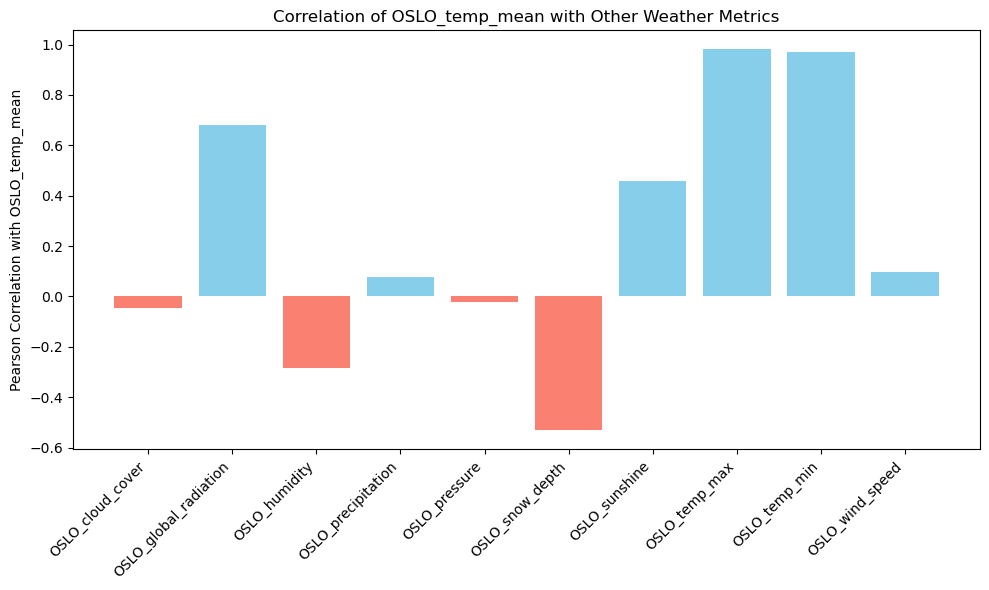

In [256]:
OSLO_weather_metrics = [
    'OSLO_cloud_cover', 'OSLO_global_radiation', 'OSLO_humidity', 'OSLO_precipitation', 'OSLO_pressure',
    'OSLO_snow_depth', 'OSLO_sunshine', 'OSLO_temp_max', 'OSLO_temp_mean', 'OSLO_temp_min', 'OSLO_wind_speed'
]

# Calculate correlation matrix
corr_matrix = weather_df[OSLO_weather_metrics].corr()

# Extract correlations of OSLO_temp_mean with others (excluding itself)
temp_corr = corr_matrix['OSLO_temp_mean'].drop('OSLO_temp_mean')

# Plot bar chart with seaborn or matplotlib
next_predictor = plt.figure(figsize=(10, 6))
# --- INSERT THESE LINES FOR COLOR SHADING ---
# Define colors based on whether the correlation is positive or negative
colors = ['skyblue' if val >= 0 else 'salmon' for val in temp_corr.values]
plt.bar(temp_corr.index, temp_corr.values, color=colors)
# --- END INSERTED LINES ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Pearson Correlation with OSLO_temp_mean')
plt.title('Correlation of OSLO_temp_mean with Other Weather Metrics')
plt.tight_layout()
plt.show()

In [258]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/next_predictor_OSLO.png'
next_predictor.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/next_predictor_OSLO.png


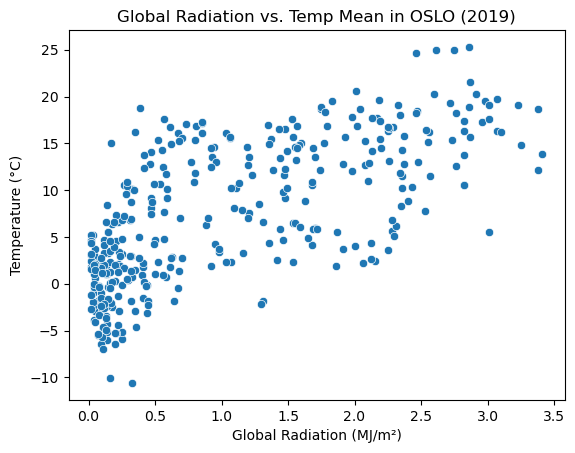

In [302]:
# Convert the 'DATE' column from string (YYYYMMDD) to datetime format
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], format='%Y%m%d')

# Narrow down to 2019
df_2019 = weather_df[weather_df['DATE'].dt.year == 2019].copy()

sns.scatterplot(x=df_2019['OSLO_global_radiation'], y=df_2019['OSLO_temp_mean'])
plt.title("Global Radiation vs. Temp Mean in OSLO (2019)") # Updated title to reflect filter
plt.xlabel("Global Radiation (MJ/m²)")
plt.ylabel("Temperature (°C)")
plt.show()

# 4. Linear Regression Model #2: `temp_mean ~ global_radiation`   

## A. (Model #2) Prepare Inputs: Extract & Transform Global Radiation-Based Temperature Data

In [292]:
# Filter and clean OSLO data for 2019
tgr_oslo_2019 = weather_df[
    (weather_df['DATE'].dt.year == 2019)
][['OSLO_global_radiation', 'OSLO_temp_mean']].dropna()

# Extract model input (X) and target (y) for training
tgr_X = tgr_oslo_2019['OSLO_global_radiation'].values.reshape(-1, 1) # Feature: global_radiation
tgr_y = tgr_oslo_2019['OSLO_temp_mean'].values.reshape(-1, 1) # Target: temperature

In [294]:
tgr_oslo_2019.head()

,OSLO_global_radiation,OSLO_temp_mean
21550,0.12,4.7
21551,0.14,1.0
21552,0.13,1.0
21553,0.09,2.3
21554,0.15,3.3


## B. (Model #2) Scale Data and Initialize Gradient Descent Set-up

In [305]:
# Store mean and std for later unscaling
tgr_y_mean = tgr_y.mean()
tgr_y_std = tgr_y.std()

# Feature scaling: normalize input and target to improve convergence
tgr_X_scaled = (tgr_X - tgr_X.mean()) / tgr_X.std()
tgr_y_scaled = (tgr_y - tgr_y.mean()) / tgr_y.std()

# Set key hyperparameters
tgr_alpha = 0.01           # Learning rate (step size for gradient descent)
tgr_n_iterations = 1000    # Total number of training iterations
tgr_m = len(tgr_X_scaled)     # Number of data points (samples)

# Initialize model parameters
tgr_theta0 = 0.0   # Intercept (bias)
tgr_theta1 = 0.0   # Weight (slope)

# Initialize tracking lists for visualization and analysis
tgr_J_history = []              # Track cost (loss) over time
tgr_theta0_history = []        # Track intercept values per iteration
tgr_theta1_history = []        # Track slope values per iteration
tgr_grad_theta0_history = []   # Track gradient of theta0 over time
tgr_grad_theta1_history = []   # Track gradient of theta1 over time


## C. (Model #2) Run Linear Model & Update Parameters via Gradient Descent

In [309]:
# Run gradient descent loop to iteratively update model parameters
for _ in range(tgr_n_iterations):
    
    # ➡️ FORWARD PASS: Predict y values using current theta values
    tgr_y_pred = tgr_theta0 + tgr_theta1 * tgr_X_scaled

    # 🧮 LOSS: Compute prediction error (residuals)
    tgr_error = tgr_y_pred - tgr_y_scaled

    # 💥 COST: Mean Squared Error (scaled by 1/2 for mathematical convenience)
    tgr_cost = (1 / (2 * tgr_m)) * np.sum(tgr_error**2)
    tgr_J_history.append(tgr_cost)

    # 📉 GRADIENT CALCULATION: Compute partial derivatives of cost w.r.t. parameters
    tgr_d_theta0 = (1 / tgr_m) * np.sum(tgr_error)                # ∂J/∂theta0
    tgr_d_theta1 = (1 / tgr_m) * np.sum(tgr_error * tgr_X_scaled)    # ∂J/∂theta1

    # Store gradients for optional plotting/debugging
    tgr_grad_theta0_history.append(tgr_d_theta0)
    tgr_grad_theta1_history.append(tgr_d_theta1)

    # 🔁 PARAMETER UPDATE: Move against gradient to minimize loss
    tgr_theta0 -= tgr_alpha * tgr_d_theta0
    tgr_theta1 -= tgr_alpha * tgr_d_theta1

    # Track updated theta values over time
    tgr_theta0_history.append(tgr_theta0)
    tgr_theta1_history.append(tgr_theta1)


## D. (Model #2) Analyze Model Performance

### 📈 Model Performance Summary: `temp_mean ~ global_radiation`

* **θ₀ (Intercept)**: −1.95 × 10⁻¹⁶
* **θ₁ (Slope)**: 0.6930
* **Final MSE (scaled)**: 0.260
* **R² Score (scaled)**: 0.480
* **Mean Absolute Error (°C)**: 4.39°C

---

The learned slope (**θ₁ ≈ 0.69**) indicates a **moderate positive relationship**: as global radiation increases, so does the predicted temperature. This makes intuitive sense—**more sunlight generally leads to warmer days**.

The model's **R² score of 0.480** means it explains **48% of the variance** in temperature—**a significant improvement** over the previous model. This suggests that global radiation is a much stronger linear predictor than time.

With a **Mean Absolute Error of 4.39°C**, the model also produces **noticeably more accurate predictions**, reducing average error by over 2°C compared to the time-based model.

---

In [313]:
### Final Parameters UPDATED FOR MANUALLY SCALED DATA
print(f"Theta 0 (intercept, scaled): {tgr_theta0}")
print(f"Theta 1 (slope, scaled): {tgr_theta1}")

### Final Loss (MSE) from Gradient Descent
tgr_final_mse = tgr_J_history[-1]
print(f"Final MSE (scaled): {tgr_final_mse:.4f}")

### R² Score (scaled)
tgr_r2 = r2_score(tgr_y_scaled, tgr_y_pred)
print(f"R² Score (scaled): {tgr_r2:.4f}")

# Convert predictions back to original scale
tgr_y_pred_real = tgr_y_pred * tgr_y_std + tgr_y_mean
tgr_y_true_real = tgr_y_scaled * tgr_y_std + tgr_y_mean  # same idea

### Mean Absolute Error (MAE) in °C
tgr_mae_real = mean_absolute_error(tgr_y_true_real, tgr_y_pred_real)
print(f"Mean Absolute Error (°C): {tgr_mae_real:.2f}")


Theta 0 (intercept, scaled): -1.9544791964469506e-16
Theta 1 (slope, scaled): 0.6930092229179455
Final MSE (scaled): 0.2598
R² Score (scaled): 0.4803
Mean Absolute Error (°C): 4.39


## E. (Model #2) Visualize Loss Curve and Parameter Paths; Compare Predictions to Actual Data

* The gradient descent progress looks **similarly smooth and stable** as in Model #1 (`temp_mean ~ time`), suggesting that both models **converged efficiently** during training.

* But gradient descent is **agnostic to meaning**—it simply minimizes loss, no matter how well the model structure fits the real-world phenomenon. Optimization in **parameter space** can succeed, even if the model is navigating the wrong landscape in **data space**.

> 🪓 Analogies: wielding a sharp machete, but clearing a path through the wrong jungle; acing a subject, but for the wrong test.

* Despite similar optimization behavior, **Model #2 outperforms Model #1** in terms of predictive power. **Global radiation** provides a **stronger, more meaningful signal** than time alone. The model captures a moderate linear relationship and yields **substantially tighter predictions**.


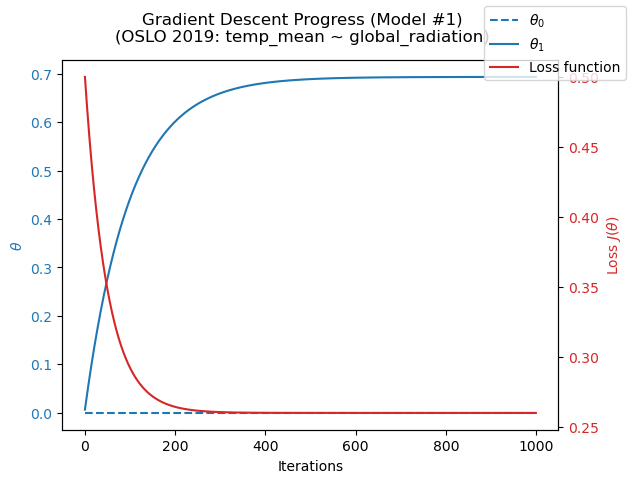

In [325]:
fig2, ax1 = plt.subplots()

# Plot theta values
color = 'tab:blue'
ax1.plot(tgr_theta0_history, label='$\\theta_0$', linestyle='--', color=color)
ax1.plot(tgr_theta1_history, label='$\\theta_1$', linestyle='-', color=color)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('$\\theta$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plot cost
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(tgr_J_history, label='Loss function', color=color)
ax2.set_ylabel('Loss $J(\\theta)$', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig2.suptitle('Gradient Descent Progress (Model #1)\n(OSLO 2019: temp_mean ~ global_radiation)')
fig2.legend()
plt.show()


In [327]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/lin_reg_model2_gradient_descent.png'
fig2.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/lin_reg_model2_gradient_descent.png


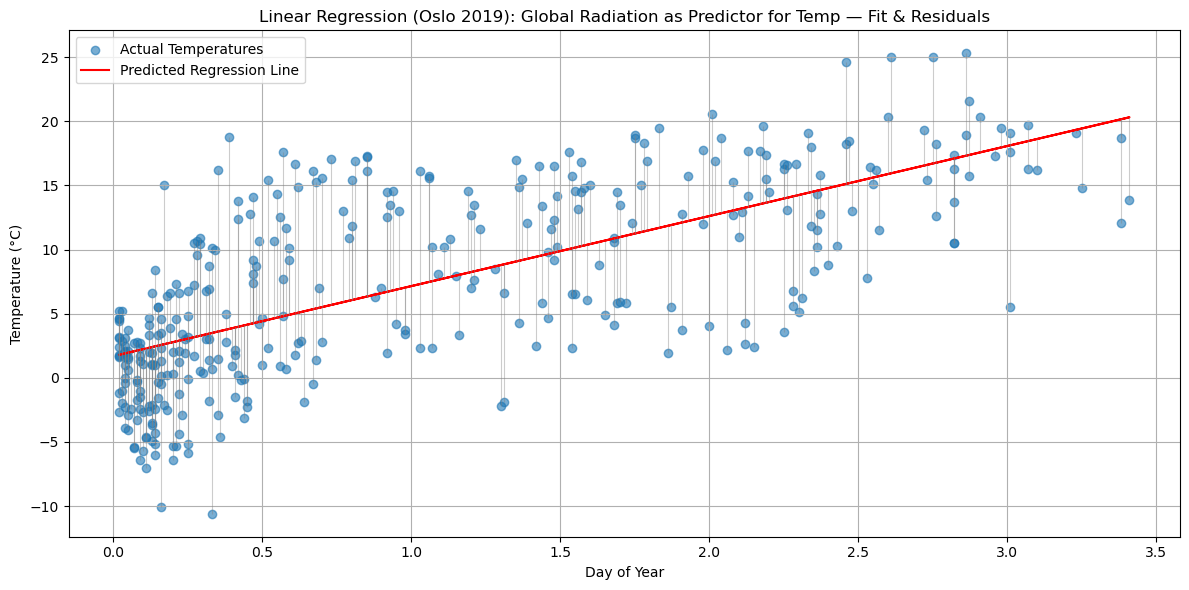

In [331]:
# X-axis: original day-of-year feature
tgr_X_days = tgr_X.flatten()  # Already 1–365, ensure 1D shape

# Plot setup
lrtgr = plt.figure(figsize=(12, 6))
plt.scatter(tgr_X_days, tgr_y_true_real, label='Actual Temperatures', alpha=0.6)
plt.plot(tgr_X_days, tgr_y_pred_real, color='red', label='Predicted Regression Line')

# Add residuals (vertical lines from prediction to true value)
for x, y_true, y_pred in zip(tgr_X_days, tgr_y_true_real, tgr_y_pred_real):
    plt.vlines(x, y_pred, y_true, color='gray', alpha=0.4, linewidth=0.8)

# Labels and formatting
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.title('Linear Regression (Oslo 2019): Global Radiation as Predictor for Temp — Fit & Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [333]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model2_lin_reg_actual_v_predicted.png'
lrtgr.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model2_lin_reg_actual_v_predicted.png


## F. (Model #2) Visualize Optimization Path on Loss Surface

#### F.1) (Model #2) Interactive 3D Loss Surfact (Plotly)

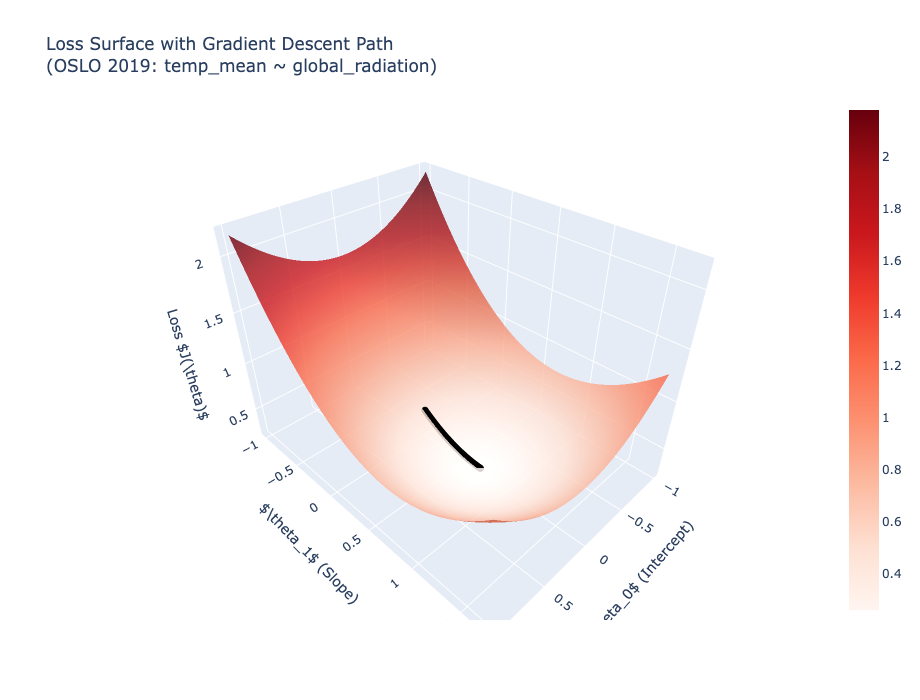

In [343]:
# Define grid for theta0 and theta1
tgr_theta0_range = np.linspace(min(tgr_theta0_history)-1, max(tgr_theta0_history)+1, 50)
tgr_theta1_range = np.linspace(min(tgr_theta1_history)-1, max(tgr_theta1_history)+1, 50)
tgr_T0, tgr_T1 = np.meshgrid(tgr_theta0_range, tgr_theta1_range)

# Compute loss surface
tgr_Z = np.zeros_like(tt_T0)
for i in range(tgr_T0.shape[0]):
    for j in range(tgr_T0.shape[1]):
        tgr_y_pred = tgr_T0[i, j] + tgr_T1[i, j] * tgr_X_scaled
        tgr_Z[i, j] = (1 / (2 * tgr_m)) * np.sum((tgr_y_pred - tgr_y_scaled) ** 2)

# Create 3D surface
tgr_surface = go.Surface(
    x=tgr_theta0_range,
    y=tgr_theta1_range,
    z=tgr_Z,
    colorscale='Reds',
    opacity=0.8,
    showscale=True,
    name='Loss Surface'
)

# Add gradient descent path
tgr_path = go.Scatter3d(
    x=tgr_theta0_history,
    y=tgr_theta1_history,
    z=tgr_J_history,
    mode='lines+markers',
    line=dict(color='black', width=5),
    marker=dict(size=4, color='black'),
    name='Gradient Descent Path'
)

figtgr = go.Figure(data=[tgr_surface, tgr_path])
figtgr.update_layout(
    scene=dict(
        xaxis_title=r'$\theta_0$ (Intercept)',
        yaxis_title=r'$\theta_1$ (Slope)',
        zaxis_title='Loss $J(\\theta)$'
    ),
    title='Loss Surface with Gradient Descent Path<br>(OSLO 2019: temp_mean ~ global_radiation)',
    width=900,
    height=700
)
figtgr.show()


---
---
---
---
### ⚠️ F.1 (Model #2) Learning Note – Comparison with Previous Non-Reproducible Model Run

In this case, both 3D surface plots appear nearly identical—suggesting that the underlying loss landscape remains consistent across runs. What stands out most is the contrast in gradient descent trajectories: across both runs of Model #2 vs. both runs of Model #1, **Model #2 exhibits a much longer, more curved descent path**.

This elongated, winding trajectory closely follows the surface’s curvature, reflecting a steeper slope and more dynamic optimization. In contrast, Model #1’s path was short and direct—indicative of a flatter, less informative loss surface.

Together, these visual cues reinforce that **Model #2 is learning from a more meaningful and structured input feature**—global radiation—whereas Model #1 (time) offered relatively little signal to optimize against.

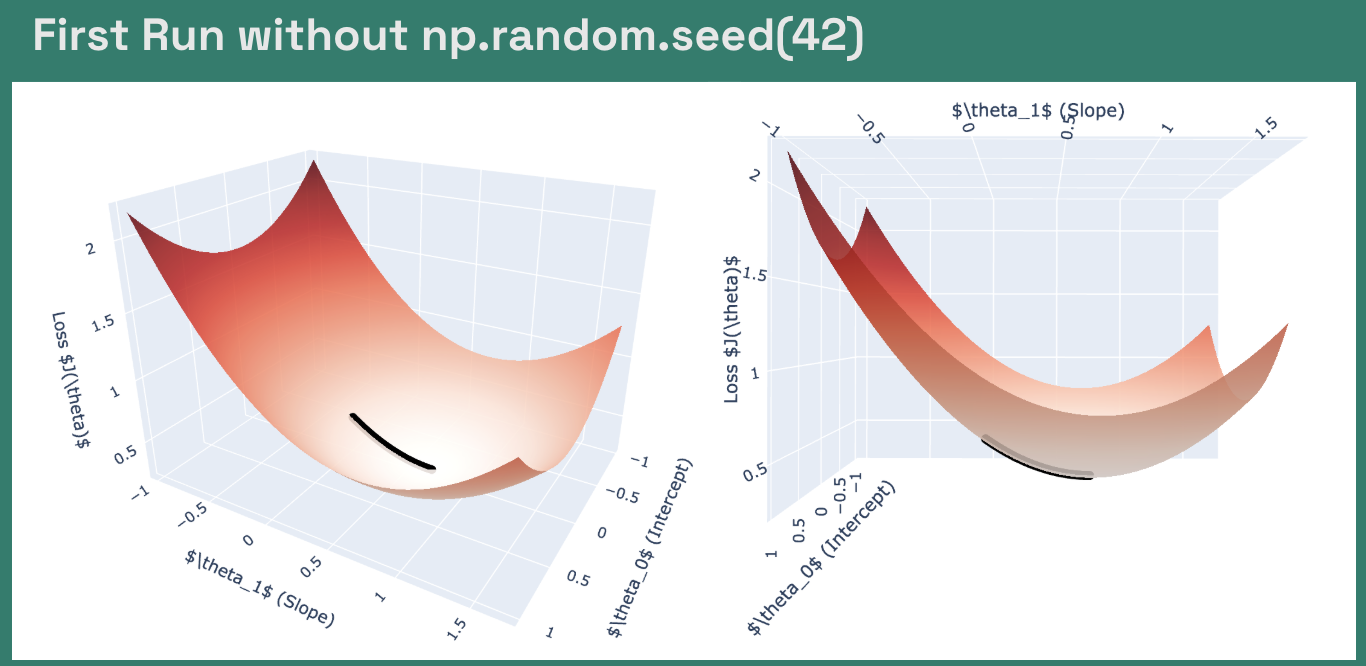


---
---
---
---

#### F.2) (Model #2) 2D Contour Plot of Loss Landscape

- Tight, concentric contours indicate a **steep and informative loss terrain**.
- Model #2’s longer descent path reflects **stronger gradients and greater depth**—the model had more structure to learn from.
- It moved efficiently toward the center, converging on a **much lower final loss (\~0.26)** compared to Model #1.

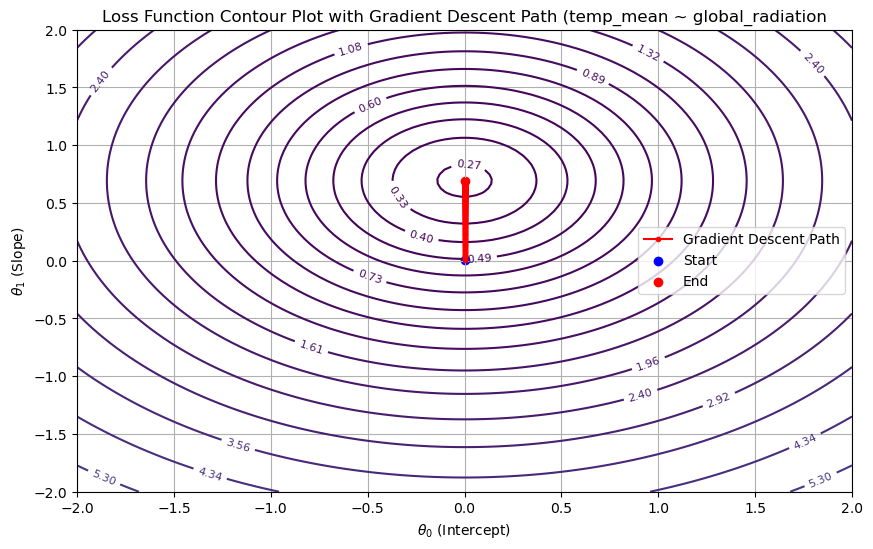

In [356]:
# Create meshgrid for θ₀ and θ₁
tgr_theta0_vals = np.linspace(-2, 2, 100)
tgr_theta1_vals = np.linspace(-2, 2, 100)
tgr_T0, tgr_T1 = np.meshgrid(tgr_theta0_vals, tgr_theta1_vals)

# Compute loss surface over the fixed grid
tgr_Z = np.zeros(tgr_T0.shape)
for i in range(tgr_T0.shape[0]):
    for j in range(tgr_T0.shape[1]):
        y_pred_grid = tgr_T0[i, j] + tgr_T1[i, j] * tgr_X_scaled
        error_grid = y_pred_grid - tgr_y_scaled
        tgr_Z[i, j] = (1 / (2 * tgr_m)) * np.sum(error_grid**2)

# Plot contours and gradient descent path
contplt_model2 = plt.figure(figsize=(10, 6))
contours = plt.contour(tgr_T0, tgr_T1, tgr_Z, levels=np.logspace(-1, 1.5, 30), cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

# Overlay gradient descent trajectory
plt.plot(tgr_theta0_history, tgr_theta1_history, 'r.-', label='Gradient Descent Path')
plt.scatter(tgr_theta0_history[0], tgr_theta1_history[0], color='blue', label='Start')
plt.scatter(tgr_theta0_history[-1], tgr_theta1_history[-1], color='red', label='End')

# Axes and legend
plt.xlabel(r'$\theta_0$ (Intercept)')
plt.ylabel(r'$\theta_1$ (Slope)')
plt.title('Loss Function Contour Plot with Gradient Descent Path (temp_mean ~ global_radiation')
plt.legend()
plt.grid(True)
plt.show()


In [376]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model2_contourplot.png'
contplt_model2.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/model2_contourplot.png


# ✅ Summary & Next Steps

In this notebook, we deepened our technical understanding of what the “learning” in machine learning involves. We trained two univariate Linear Regression models:

* **Model #1** used **time** as a predictor for temperature.
* **Model #2** used **global radiation**—a more informative and physically grounded feature—as the predictor.

We compared their predictive performance, gradient descent paths, and learned parameters.

The core insight: **Gradient descent visualizations reveal how the model navigates "parameter space" to minimize loss—not the quality of relationships in "data space."** A model can optimize efficiently even when it learns from a weak or misaligned input feature.

---

> 🌱 **Next Step:**
> The upcoming notebooks shift focus to multivariate classification models. Our goal is to identify which model best supports **ClimateWins' mission** of predicting *pleasant vs. unpleasant* weather days.
> Next: **Artificial Neural Networks**.

---